In [1]:
%matplotlib inline
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

In [2]:
import timeseries as ts
import numpy as np

from scipy.stats import norm

# m is the mean, s is the standard deviation, and j is the jitter
# the meta just fills in values for order and blarg from the schema
def tsmaker(m, s, j):
    "returns metadata and a time series in the shape of a jittered normal"
    meta={}
    meta['order'] = int(np.random.choice([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]))
    meta['blarg'] = int(np.random.choice([1, 2]))
    t = np.arange(0.0, 1.0, 0.01)
    v = norm.pdf(t, m, s) + j*np.random.randn(100)
    return meta, ts.TimeSeries(t, v)

Generating LALR tables


In [3]:
"""
Helper functions for making requests

insert_ts(self, primary_key, ts):

upsert_meta(self, primary_key, metadata_dict)

add_trigger(self, proc, onwhat, target, arg)

remove_trigger(self, proc, onwhat)

augmented_select(self, proc, target, arg=None, metadata_dict={}, additional=None)

select(self, metadata_dict={}, fields=None, additional=None)
"""
def make_insert_ts(primary_key,t):
    return json.dumps({'primary_key':primary_key, 'ts':t.to_json()})

def make_upsert_meta(primary_key, metadata_dict):
    return json.dumps({'primary_key':primary_key, 'metadata_dict': metadata_dict})

def make_add_trigger(proc, onwhat, target, arg):
    if hasattr(arg,'to_json'):
        arg = arg.to_json()
    return json.dumps({'proc':proc,'onwhat':onwhat,'target':target,'arg':arg})

def make_remove_trigger(proc, onwhat):
    return json.dumps({'proc':proc,'onwhat':onwhat})


In [4]:
server_url = 'http://localhost:8080/tsdb'
# server_url = 'http://www.adjch.me:8080/tsdb'
# add a trigger. notice the argument. It does not do anything here but
# could be used to save a shlep of data from client to server.

r = requests.post(server_url+'/add/trigger',make_add_trigger('junk', 'insert_ts', None, 'db:one:ts'))
assert r.status_code == 200

r = requests.post(server_url+'/add/trigger',make_add_trigger('stats', 'insert_ts', ['mean', 'std'], None))
assert r.status_code == 200



In [5]:
N_ts = 50
N_vp = 5

#Set up 50 time series
mus = np.random.uniform(low=0.0, high=1.0, size=N_ts)
sigs = np.random.uniform(low=0.05, high=0.4, size=N_ts)
jits = np.random.uniform(low=0.05, high=0.2, size=N_ts)

# dictionaries for time series and their metadata
tsdict={}
metadict={}
for i, m, s, j in zip(range(N_ts), mus, sigs, jits):
    meta, tsrs = tsmaker(m, s, j)
    # the primary key format is ts-1, ts-2, etc
    pk = "ts-{}".format(i)
    tsdict[pk] = tsrs
    meta['vp'] = False # augment metadata with a boolean asking if this is a  VP.
    metadict[pk] = meta

# choose 5 distinct vantage point time series
vpkeys = ["ts-{}".format(i) for i in np.random.choice(range(N_ts), size=N_vp, replace=False)]
for i in range(N_vp):
    # add 5 triggers to upsert distances to these vantage points
    requests.post(server_url+'/add/trigger',
                  make_add_trigger('corr', 'insert_ts', ["d_vp-{}".format(i)], tsdict[vpkeys[i]]))
    # change the metadata for the vantage points to have meta['vp']=True
    metadict[vpkeys[i]]['vp']=True
# Having set up the triggers, now inser the time series, and upsert the metadata
for k in tsdict:
    requests.post(server_url+'/add/ts',
                  make_insert_ts(k, tsdict[k]))
    requests.post(server_url+'/add/metadata',
                  make_upsert_meta(k, metadict[k]))

print("UPSERTS FINISHED")

UPSERTS FINISHED


In [6]:
payload = {}
requests.get(server_url+'/select',params={'query':json.dumps(payload)}).content

b'{"ts-11": {}, "ts-13": {}, "ts-42": {}, "ts-17": {}, "ts-8": {}, "ts-23": {}, "ts-27": {}, "ts-26": {}, "ts-40": {}, "ts-38": {}, "ts-18": {}, "ts-35": {}, "ts-15": {}, "ts-14": {}, "ts-0": {}, "ts-48": {}, "ts-28": {}, "ts-43": {}, "ts-45": {}, "ts-20": {}, "ts-7": {}, "ts-47": {}, "ts-44": {}, "ts-16": {}, "ts-21": {}, "ts-3": {}, "ts-31": {}, "ts-32": {}, "ts-41": {}, "ts-34": {}, "ts-37": {}, "ts-36": {}, "ts-1": {}, "ts-39": {}, "ts-22": {}, "ts-12": {}, "ts-19": {}, "ts-4": {}, "ts-49": {}, "ts-29": {}, "ts-33": {}, "ts-46": {}, "ts-30": {}, "ts-9": {}, "ts-5": {}, "ts-25": {}, "ts-24": {}, "ts-10": {}, "ts-6": {}, "ts-2": {}}'

In [7]:
query = {'where':{'order': {'>=' : 1}},'fields':['order','vp'],'additional':{'sort_by':'+order','limit':10}}
requests.get(server_url+'/select',params={'query':json.dumps(query)}).content

b'{"ts-17": {"order": 1, "vp": false}, "ts-8": {"order": 1, "vp": false}, "ts-35": {"order": 1, "vp": false}, "ts-16": {"order": 1, "vp": false}, "ts-40": {"order": 2, "vp": false}, "ts-21": {"order": 2, "vp": false}, "ts-29": {"order": 2, "vp": false}, "ts-9": {"order": 2, "vp": false}, "ts-37": {"order": 3, "vp": false}, "ts-4": {"order": 3, "vp": false}}'

In [8]:
print('------now computing vantage point stuff---------------------')
print("VPS", vpkeys)

#we first create a query time series.
_, query = tsmaker(0.5, 0.2, 0.1)

# Step 1: in the vpdist key, get  distances from query to vantage points
# this is an augmented select
vpdist = {}
payload = {'proc':'corr','target':'d','arg':query.to_json()}
for v in vpkeys:
    payload['where'] = {'pk': v}
    r = requests.get(server_url+'/augselect',params={'query':json.dumps(payload)})
    results = json.loads(r.content.decode('utf-8'))
    vpdist[v] = results[v]['d']

------now computing vantage point stuff---------------------
VPS ['ts-45', 'ts-44', 'ts-26', 'ts-2', 'ts-12']


VP DIST
{'ts-44': 0.08944768753122484, 'ts-26': 0.520015203581962, 'ts-45': 0.7206558502350681, 'ts-2': 0.6959542640348672, 'ts-12': 0.601790901955971}


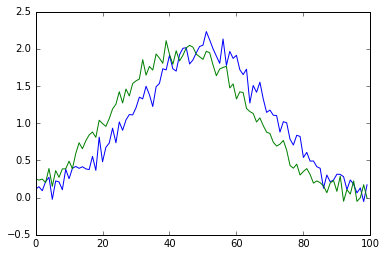

In [9]:
#1b: choose the lowest distance vantage point
# you can do this in local code
print("VP DIST")
print(vpdist)
closest_vpk = min(vpkeys,key=lambda v:vpdist[v])

# Step 2: find all time series within 2*d(query, nearest_vp_to_query)
#this is an augmented select to the same proc in correlation
payload = {'proc':'corr','target':'d','arg':query.to_json()}
payload['where'] = {'d_'+closest_vpk: {'<=': 2*vpdist[closest_vpk]}}
r = requests.get(server_url+'/augselect',params={'query':json.dumps(payload)})
results = json.loads(r.content.decode('utf-8'))

#2b: find the smallest distance amongst this ( or k smallest)
#you can do this in local code
nearestwanted = min(results.keys(),key=lambda p: results[p]['d'])

plt.plot(query)
plt.plot(tsdict[nearestwanted])
